Importing all necessary libraries for handling data (pandas, numpy), pulling price data (yfinance) and plotting (matplotlib). On my environment I had to install the library "yfinance" before actually importing it. I used the command: 

    !conda install -c conda-forge yfinance -y

In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf 
import matplotlib.pyplot as plt 

I was getting a YFRateLimitError after running the below cell. After some cave-dwelling on stackoverflow I was able to patch things up running the command:

    pip install --upgrade yfinance 

Downloading Bitcoin's daily prices: (My analysis starts at the previous market cycle top; i am pulling data 200 days before this so that my moving averages can be calculated) 

In [2]:
data = yf.download('BTC-USD', start='2020-01-23', end ='2025-01-01')
data['Returns'] = data['Close'].pct_change()
data.head() #checking the column names and looking for any apparent issue in my data.

/var/folders/_d/j0wpjgqn1wl3d9jzg0wkdn280000gn/T/ipykernel_44641/3622140097.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BTC-USD', start='2020-01-23', end ='2025-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Returns
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,
Date,,,,,,
2020-01-23,8406.515625,8687.747070,8333.637695,8680.650391,25770680779,NaN
2020-01-24,8445.434570,8514.666992,8266.840820,8405.567383,24397913026,0.004630
2020-01-25,8367.847656,8458.453125,8296.218750,8440.119141,19647331549,-0.009187
2020-01-26,8596.830078,8602.401367,8325.498047,8364.410156,22177678796,0.027365
2020-01-27,8909.819336,8977.726562,8597.308594,8597.308594,28647338393,0.036408


<Axes: xlabel='Date'>

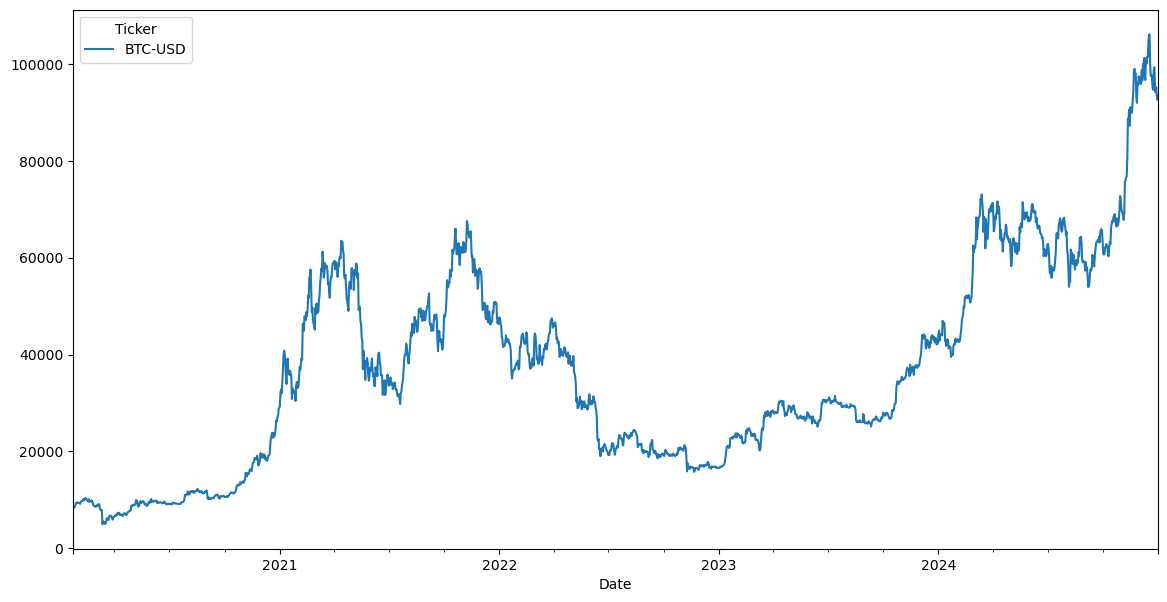

In [3]:
data['Close'].plot(figsize=(14,7))
#"ALWAYS GRAPH THE DATA" my econometrics professor keeps saying.

Momentum Strategy: 

I will use the 50day and 200day moving average. The idea is that when 50MA > 200MA, BTC has generated momentum on the upside and I go long. When 50MA < 200MA i go short. Now, the lenght of the moving averages is indeed taken a bit arbitrarily; the 200MA seems to hold historical significance on the BTC chart and provide reliable support on a bull market. When btc is below it, on the other hand, we are sure to be on a bear market. The 50 day is much quicker to respond and basically looks good in my eyes when i put it in a chart. 


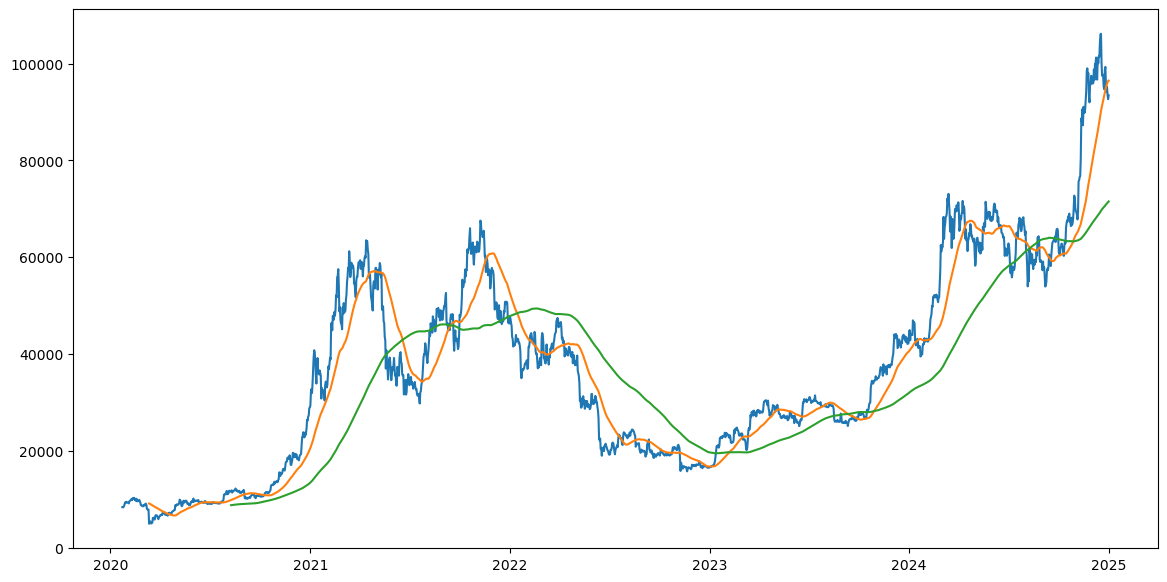

In [4]:
#Constructing the Moving Averages and plotting them 
data['MA50']=data['Close'].rolling(50).mean()
data['MA200']=data['Close'].rolling(200).mean()
data_bullrun= data.loc['2023-03-21':]
plt.figure(figsize = (14,7))
plt.plot(data['Close'])
plt.plot(data['MA50'])
plt.plot(data['MA200'])

Data looks good and the Moving Averages are loaded. I am starting my analysis on March 2023 where BTC successfully held the 200MA as support, signaling a bull market. 




In [5]:
#Momentum Strategy
data['Momentum_signal'] = np.where(data['MA50']>data['MA200'],1, -1)
data['Momentum_strategy'] = data['Momentum_signal'].shift(1)*data['Returns']

Mean-Reversion Strategy: 

Here I am making the assumption that when BTC reaches the upper limit of the Bollinger Band indicator it is overbought and due for a correction. When it falls to the lower limit of the indicator the asset is oversold. A signal is produced in each scenario that we suppose triggers a long and short respectively. 

Text(0.5, 1.0, 'BTCUSD w. Bollinger Bands')

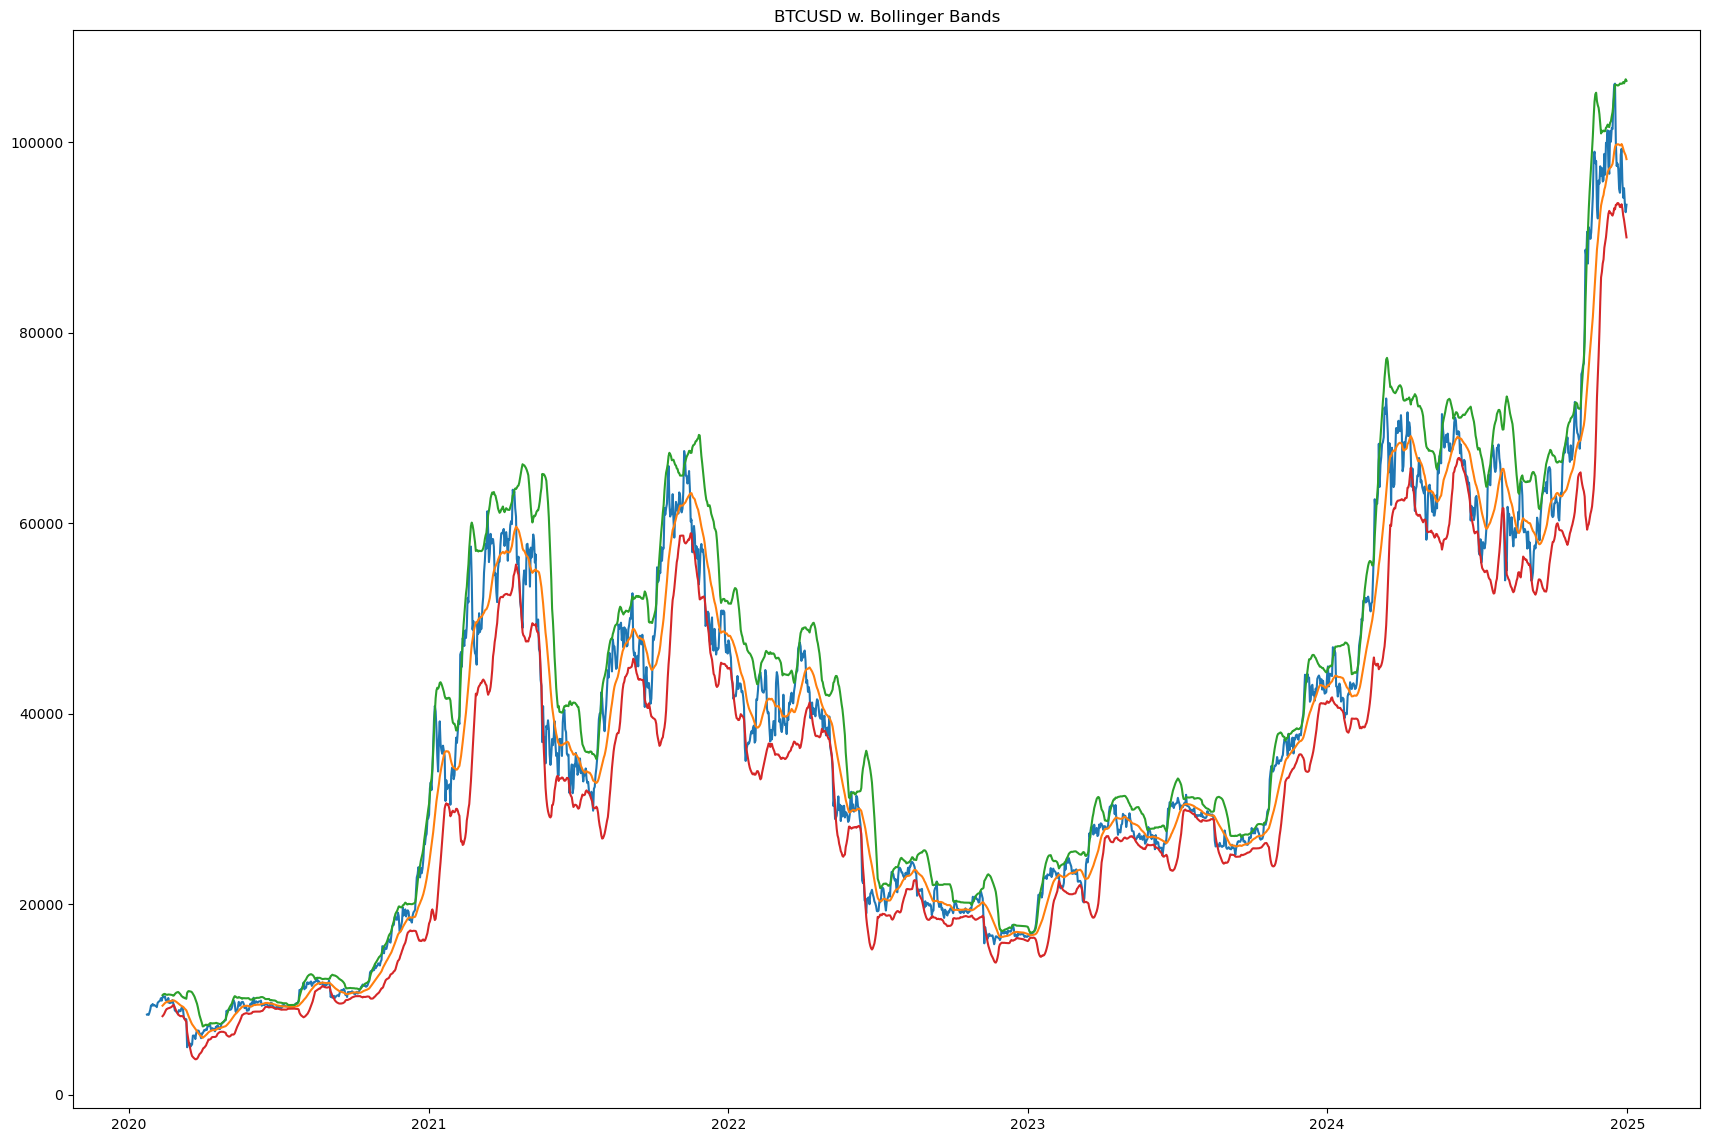

In [6]:
#had issues with indexing on the strategy, using this as a fix 
price_series = data['Close']
if isinstance(price_series, pd.DataFrame):
    price_series= price_series.iloc[:, 0]


data1=pd.DataFrame({'Close' : price_series}).copy()

#Constructing a Bollinger_Bands indicator with a MA length of 20 days
data1['MA20'] = data1['Close'].rolling(20).mean()
data1['STD20']=data1['Close'].rolling(20).std()
data1['Upper']=data1['MA20'] + 2*data1['STD20']
data1['Lower'] = data1['MA20'] - 2*data1['STD20']
#Plotting the graph with the indicator
plt.figure(figsize=(21,14))
plt.plot(data1['Close'])
plt.plot(data1['MA20'])
plt.plot(data1['Upper'])
plt.plot(data1['Lower'])
plt.title('BTCUSD w. Bollinger Bands')

In [7]:
dataMR=data1.dropna().copy()
dataMR.head()

,Close,MA20,STD20,Upper,Lower
Date,,,,,
2020-02-11,10208.236328,9332.936182,549.985311,10432.906804,8232.965559
2020-02-12,10326.054688,9428.913135,547.289533,10523.492200,8334.334070
2020-02-13,10214.379883,9517.360400,522.356017,10562.072435,8472.648366
2020-02-14,10312.116211,9614.573828,476.031213,10566.636255,8662.511402
2020-02-15,9889.424805,9679.203564,414.329469,10507.862502,8850.544627


In [8]:
#Mean-Reversion Strategy

#initialising the Signal and caclulating returns for the new dataset 
dataMR['MR_Signal']=0
dataMR['Returns'] = dataMR['Close'].pct_change()

#Mean-Reversion signal 
dataMR.loc[dataMR['Close'] < dataMR['Lower'], 'MR_Signal']=1 
dataMR.loc[dataMR['Close']> dataMR['Lower'],'MR_Signal'] = -1

dataMR['MR_Signal']=dataMR['MR_Signal'].astype(int) #not sure if its necessary, keeping it for "psycological" reasons

dataMR['MR_Strategy']=dataMR['MR_Signal'].shift(1).fillna(0)*dataMR['Returns'].fillna(0)

Performance Metrics:

In [9]:
import numpy as np

def strategy_performance(returns, trading_days=252):
    #Compute performance metrics for a strategy.
    #Input: returns = Series of daily strategy returns
    
    returns = returns.dropna()
    
    # cumulative return
    cumulative_return = (1 + returns).prod() - 1
    
    # annualized return
    ann_return = (1 + cumulative_return) ** (trading_days / len(returns)) - 1
    
    # annualized volatility
    ann_vol = returns.std() * np.sqrt(trading_days)
    
    # Sharpe ratio (risk-adjusted return)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
    
    # Max drawdown
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    return {
        "Cumulative Return": f"{cumulative_return:.2%}",
        "Annualized Return": f"{ann_return:.2%}",
        "Annualized Volatility": f"{ann_vol:.2%}",
        "Sharpe Ratio": round(sharpe, 2),
        "Max Drawdown": f"{max_drawdown:.2%}"
    }

In [10]:
momentum_metrics = strategy_performance(data['Momentum_strategy'])
print("Momentum Strategy Performance:")
print(momentum_metrics)

Momentum Strategy Performance:
{'Cumulative Return': '71.69%', 'Annualized Return': '7.84%', 'Annualized Volatility': '53.38%', 'Sharpe Ratio': 0.15, 'Max Drawdown': '-72.94%'}


In [11]:
mr_metrics = strategy_performance(dataMR['MR_Strategy'])
print("\nMean-Reversion Strategy Performance:")
print(mr_metrics)


Mean-Reversion Strategy Performance:
{'Cumulative Return': '-98.99%', 'Annualized Return': '-47.72%', 'Annualized Volatility': '53.43%', 'Sharpe Ratio': -0.89, 'Max Drawdown': '-99.47%'}


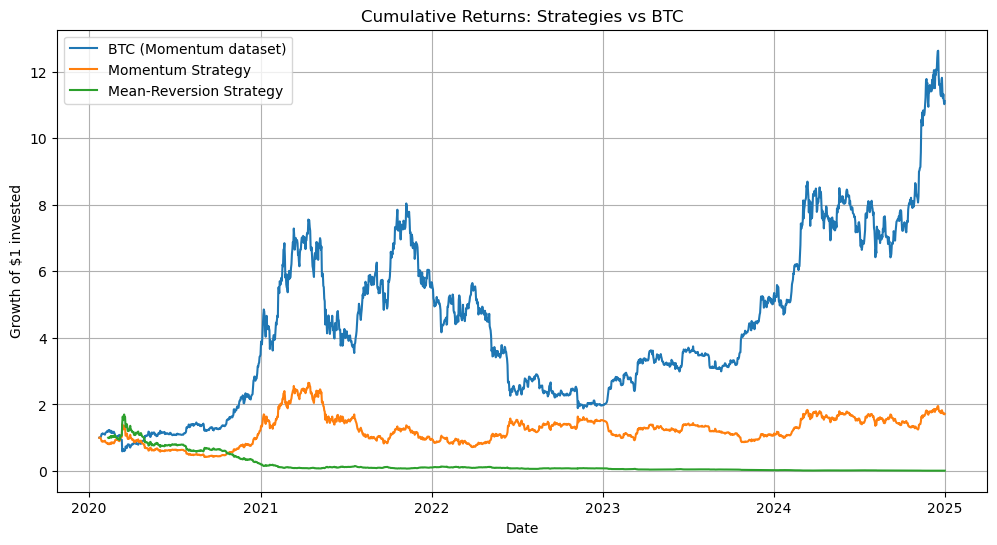

In [12]:
import matplotlib.pyplot as plt

def cumulative_returns(returns):
    #Turn daily returns into a cumulative growth series (starting at 1)
    return (1 + returns.fillna(0)).cumprod()

#Build cumulative returns series for each dataset
btc_buyhold_mom = cumulative_returns(data['Returns'])

momentum_cum = cumulative_returns(data['Momentum_strategy'])
mr_cum       = cumulative_returns(dataMR['MR_Strategy'])

#Align all on a common index (outer join to keep all dates)
combined = pd.concat([
    btc_buyhold_mom.rename("BTC (Momentum dataset)"),
    momentum_cum.rename("Momentum Strategy"),
    mr_cum.rename("Mean-Reversion Strategy")
], axis=1)

#Plot
plt.figure(figsize=(12,6))
for col in combined.columns:
    plt.plot(combined.index, combined[col], label=col)

plt.title("Cumulative Returns: Strategies vs BTC")
plt.ylabel("Growth of $1 invested")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

Comments: 

Mean-Reversion Strategy:

The strategy performed extremely poorly, with a nearly complete capital loss (–98.99% cumulative return and –99.47% max drawdown).

This aligns with the fact that Bitcoin is a structurally trending asset over long horizons. Its secular growth means that pullbacks (which a mean-reversion strategy interprets as buy signals) often extend further into prolonged downtrends, while breakouts (interpreted as sell signals) frequently continue upward. This is also visible from our chart of the bollinger bands.

In essence, BTC’s tendency to trend strongly in one direction invalidates classical mean-reversion assumptions. What might classify as overbought may simply be the start of a new parabolic run and what looks oversold may precede further drawdowns.
As a result, the mean-reversion framework is systematically fighting the market’s dominant behavior, leading to persistent losses.

Momentum Strategy:

The momentum approach captured Bitcoin’s trending nature better, delivering a positive cumulative return of +71.69%.

However, the Sharpe ratio (0.15) and large max drawdown (–72.94%) show that while momentum is directionally aligned with BTC’s price action, implementation still lacks robustness.

This suggests room for optimization (e.g., better entry/exit timing, risk management, dynamic position sizing!).